<a href="https://colab.research.google.com/github/ytg32/tekno2021-object-detection/blob/main/CustomVisDroneLoader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
!git clone https://github.com/dronefreak/VisDrone-dataset-python-toolkit.git

Cloning into 'VisDrone-dataset-python-toolkit'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 153 (delta 9), reused 9 (delta 2), pack-reused 132
Receiving objects: 100% (153/153), 467.42 MiB | 22.83 MiB/s, done.
Resolving deltas: 100% (49/49), done.
Checking out files: 100% (85/85), done.


In [ ]:
!unzip /content/drive/MyDrive/VisDrone2019-DET-train/VisDrone2019-DET-train.zip

In [ ]:
!python /content/VisDrone-dataset-python-toolkit/convertVis_to_xml.py

In [18]:
from detectron2.structures import BoxMode

In [ ]:
'''
  ignored regions(0), pedestrian(1), people(2), bicycle(3), car(4), van(5), truck(6),
  tricycle(7), awning-tricycle(8), bus(9), motor(10), others(11)
'''

In [99]:
from google.colab.patches import cv2_imshow
#/content/VisDrone2019-DET-train/annotations
def get_visdrone_dicts(img_path, annot_path):
  dataset_dicts = []
  for path, subdirs, files in os.walk(img_path):
   for filename in files:
     record = {}
     
     img_p = os.path.join(path, filename)
     anot_p = os.path.join(annot_path, filename[:-4] + '.txt')

     height, width = cv2.imread(img_p).shape[:2]

     record["file_name"] = img_p
     record["image_id"] = filename
     record["height"] = height
     record["width"] = width

     objs = []

     with open(anot_p) as fp:
       line = fp.readline()
       while line:
         line = line.replace("\n","") 
         vals = list(map(int,line.split (",")))
         id = vals[5]

         if id == 0 or id == 11:
           line = fp.readline()
           continue
        
         b_left, b_top, b_width, b_height = vals[:4]
         b_right, b_bottom = b_left + b_width, b_top - height
         
         obj = {
            "bbox": [b_left, b_bottom, b_width, b_height],
            "bbox_mode": BoxMode.XYWH_ABS,
            "segmentation": [],
            "category_id": id,
         }
         
         objs.append(obj)
         line = fp.readline()
         record["annotations"] = objs
         dataset_dicts.append(record)
         #print(dataset_dicts)
     return dataset_dicts
     #print(img_p)
     #cv2_imshow(image)
     

In [ ]:
rec = get_visdrone_dicts("/content/VisDrone2019-DET-train/images", "/content/VisDrone2019-DET-train/annotations")
rec

In [ ]:
DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])

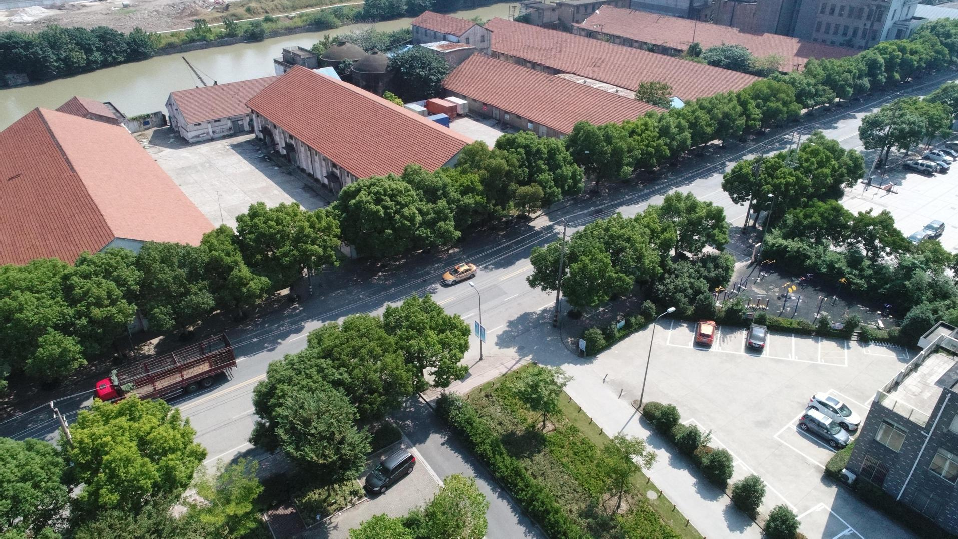

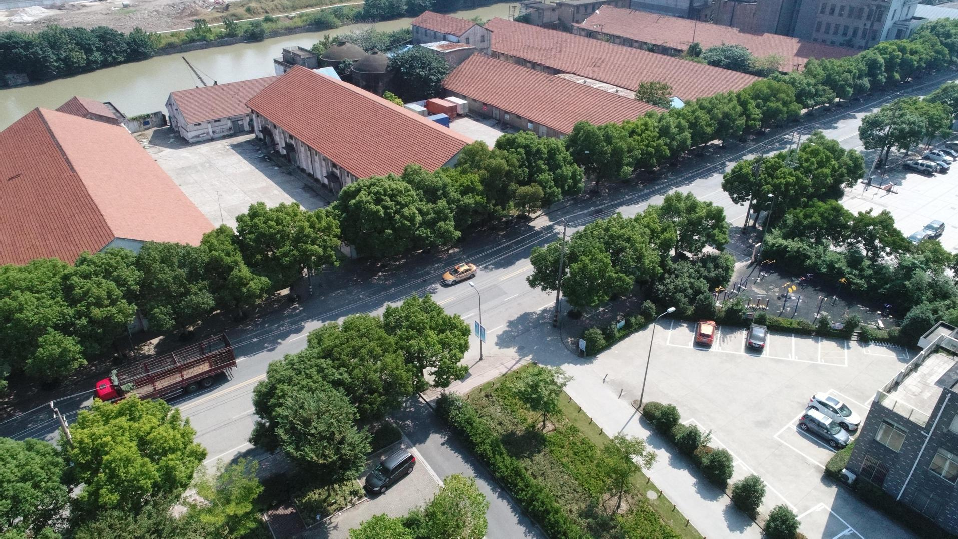

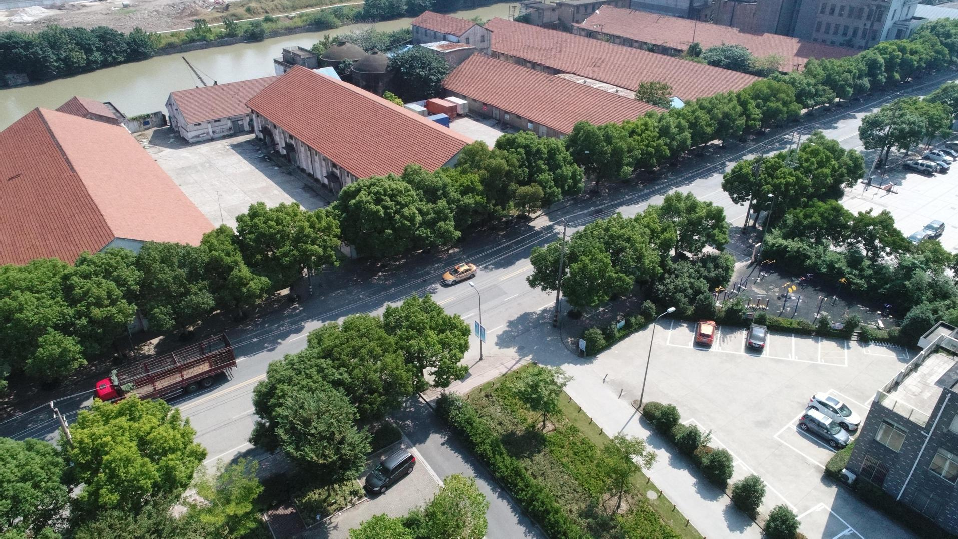

In [103]:
dataset_dicts = get_visdrone_dicts("/content/VisDrone2019-DET-train/images", "/content/VisDrone2019-DET-train/annotations")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])